In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems
from CoupledQuantumSystems.IFQ import gfIFQ
import scqubits

In [60]:
def visualize_c_ops(c_ops,evals):
    level_to_x = {
        0:1,
        1:0,
        2:2,
        3:1,
        4:0,
        5:1,
        6:2,
        7:-1.5,
        8:-0.5,
        9:0.5,
        10:1.5,
        11:2.5,
        12:3.5,
        13:-0.5,
        14:1.5,
        15:2.5,
        16:3.5,
        17:4.5,
        18:5.5,
        19:6.5,

    }
    def plot_levels(ax):
        for ql,eval in enumerate(evals):
            eval_with_2pi = 2*np.pi*eval
            x = level_to_x[ql]
            length = 0.3
            ax.plot([x-length,x+length], [eval_with_2pi,eval_with_2pi])
            ax.text(x,eval_with_2pi-3,f"{ql}",va='center',ha='center',fontsize=10)
    def plot_thermalization(ax):
        max_element = np.max(np.abs(np.square((c_ops.full()))))
        max_lw = 4
        lw_scaling_ratio = max_lw/max_element
        decay_color = '#4999c3'
        heating_color = '#d5373d'
        for i in range(len(evals)):
            for j in range(len(evals)):
                if i == j:
                    continue
                else:
                    i_y = 2*np.pi*evals[i]
                    j_y = 2*np.pi*evals[j]
                    i_x = level_to_x[i]
                    j_x = level_to_x[j]
                    lw = lw_scaling_ratio* np.abs(np.square((c_ops[i,j])))
                    if lw > 0.01:
                        if i < j:
                            ax.plot([i_x+0.1,j_x+0.1], [i_y,j_y], color = decay_color , lw = lw )
                        else:
                            ax.plot([i_x-0.1,j_x-0.1], [i_y,j_y], color = heating_color , lw = lw )
                if i == j-1:
                    i_y = 2*np.pi*evals[i]
                    j_y = 2*np.pi*evals[j]
                    i_x = level_to_x[i]
                    j_x = level_to_x[j]
                    ax.text((i_x+j_x)/2, (i_y+j_y)/2, f'{evals[j]-evals[i]:.2f}',va='center',ha='center',size = 6 )
    fig, ax = plt.subplots(1,1,figsize = (5,5))
    plot_levels(ax)
    plot_thermalization(ax)
    return fig,ax

from matplotlib.colors import LogNorm
def plot_abs_heatmap(data,rtol_text = None,atol_text = None,digits = 0):
    abs_data = np.abs(data)
    fig, ax = plt.subplots()
    vmin = 1e-10
    vmax = np.max(abs_data)
    if rtol_text != None:
        tol = vmax * rtol_text
    elif atol_text != None:
        tol = atol_text
    else:
        tol = vmax * 1e-3
    abs_data[abs_data<vmin]=vmin
    heatmap = ax.imshow(abs_data,norm=LogNorm(vmin=vmin,vmax=vmax), cmap='viridis', origin='lower')
    cbar = plt.colorbar(heatmap, ax=ax)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if abs_data[i, j] >tol:
                if digits == 0:
                    text = f"{abs_data[i, j]:.0e}"
                elif digits == 1:
                    text = f"{abs_data[i, j]:.1e}"
                else:
                    raise Exception(f"Jiakai didn't define this behavior")
                ax.text(j, i, text, ha="center", va="center", color="w")
    ax.set_title('Heatmap of Absolute Values')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')    
    return fig, ax

# get bare decay rates

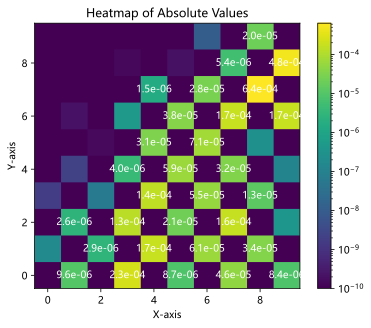

In [61]:
# Initialize hamiltonian
max_ql = 10
max_ol = 5
EJ = 4
EC = EJ/2.7
EL = EJ/45
gf_IFQ = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=max_ql)

temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

qbt_c_ops=gf_IFQ.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)

evals = gf_IFQ.fluxonium.eigenvals(evals_count=gf_IFQ.truncated_dim)
qls = list(range(max_ql))

fig, ax = plot_abs_heatmap(np.square(qbt_c_ops.full()),digits=1)

In [62]:
print(f"bare 8-7 decay rate {np.square(qbt_c_ops.full())[7,8].real:.2e}")

bare 8-7 decay rate 6.36e-04


# Create coupled system, compute product state to dressed state correspondance

In [63]:
resonator_hybrid_ql1 = 1
resonator_hybrid_ql2 = 4
Er =np.abs(evals[resonator_hybrid_ql2]-evals[resonator_hybrid_ql1])-0.05
Er

4.660870022188891

In [64]:
osc = scqubits.Oscillator(E_osc=Er, truncated_dim=max_ol, l_osc=1.0)

g = 0.05
system  =  FluxoniumOscillatorSystem(
                qbt = gf_IFQ.fluxonium,
                osc = osc,
                g_strength = g,
                products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
                computaional_states = '0,2',
                )
qbt_c_ops_wrapped = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis((qbt_c_ops[:, :],system.qbt),
                                                                            op_in_bare_eigenbasis = True)[:, :])
osc_c_ops_wrapped = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(system.osc.annihilation_operator)[:, :])

kappa_osc  = 2e-3
c_ops = [
    np.sqrt(kappa_osc) * osc_c_ops_wrapped,  
    # qbt_c_ops_wrapped
    ]

In [65]:
id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
id_wrapped_fluxonium_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
resonator_destory_arr= id_wrapped_resonator_destory.full()
fluxonium_creation_arr = id_wrapped_fluxonium_destory.dag().full()
fluxonium_destory_arr= id_wrapped_fluxonium_destory.full()

ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)

def find_next_in_branch(dressed_idx_of_qubit_i_resonator_n:int):
    return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
diagonalization_idx_arr_with_marks = np.zeros((max_ql,max_ol),dtype=int)
overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        diagonalization_idx_arr_with_marks[ql,ol] = system.product_to_dressed[(ql,ol)]

        if ol < 1:
            overlap_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        else:
            overlap_idx_arr[ql,ol] = np.argmax(ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

diff_indices = np.argwhere(diagonalization_idx_arr != overlap_idx_arr)
qbt_indices_to_show_in_color = np.unique(diff_indices[:, 0])

print(f"is the assignment using branch same assignment from overlap?\n {np.allclose(diagonalization_idx_arr, overlap_idx_arr)}")

is the assignment using branch same assignment from overlap?
 True


 /tmp/ipykernel_441831/631188281.py: 18ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_441831/631188281.py: 20

(<Figure size 400x300 with 1 Axes>, <Axes: xlabel='$N_r$', ylabel='$N_f$'>)

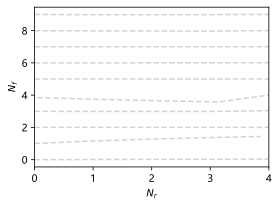

In [66]:
def plot_branches(overlap_idx_arr,max_ql,max_ol,qbt_indices_to_show_in_color,resonator_destory_arr,fluxonium_destory_arr,evecs):
    # print hybridization of branches
    fig,ax = plt.subplots(1,1,figsize=(4,3))
    qls = list(range(max_ql))

    for ql in qls:
        linestyle = '-'
        if ql in qbt_indices_to_show_in_color:
            color = None#'#4999c3'
        else:
            color = 'lightgrey'
            linestyle = '--'
        dressed_idx_arr = overlap_idx_arr[ql]
        photon_num_arr = np.zeros((max_ol))
        fluxonium_num_arr = np.zeros((max_ol))
        for ol in range(max_ol):
            state_after_a = resonator_destory_arr @ evecs[dressed_idx_arr[ol]].full()
            photon_num_arr[ol] = np.sum(state_after_a**2)
            state_after_fluxnonium_a = fluxonium_destory_arr @ evecs[dressed_idx_arr[ol]].full()
            fluxonium_num_arr[ol] = np.sum(state_after_fluxnonium_a**2)

        ax.plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}',color=color,linestyle=linestyle)

    ax.set_xlim(0,max_ol-1)
    ax.set_xlabel(r'$N_r$')
    ax.set_ylabel(r'$N_f$')

    plt.tight_layout()
    return fig,ax

plot_branches(overlap_idx_arr,max_ql,max_ol,qbt_indices_to_show_in_color,resonator_destory_arr,fluxonium_destory_arr,system.evecs)
# fig.savefig('hybridization.pdf')

In [67]:
# Adjust dressed to product assignment
for i in range(max_ql):
    for j in range(max_ol):
        system.product_to_dressed[(i,j)] =  overlap_idx_arr[i,j] 

system.set_sign_multiplier()

# Get dressed fluxonium decay rates associated with resonator at 0 photon

In [68]:
kappa_osc= 1e-2

In [69]:
new_ql1 = system.product_to_dressed[(ql1,0)]
new_ql2 = system.product_to_dressed[(ql2,0)]

print(f"bare 8-7 decay rate {np.abs(qbt_c_ops_wrapped.full())[new_ql1,new_ql2]:.2e}")
print(f"bare 8-7 decay rate {np.abs(kappa_osc*osc_c_ops_wrapped.full())[new_ql1,new_ql2]:.2e}")



bare 8-7 decay rate 0.00e+00
bare 8-7 decay rate 0.00e+00


 /tmp/ipykernel_441831/3876608000.py: 8

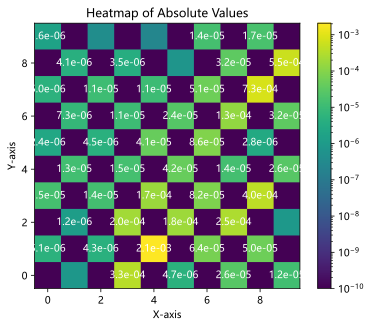

In [70]:

qbt_transition_in_osc_decay = np.zeros(shape=(max_ql,max_ql))
osc_c_ops_wrapped_arr = kappa_osc*osc_c_ops_wrapped.full()
qbt_c_ops_wrapped_arr = np.square(qbt_c_ops_wrapped.full())
for ql1 in qls:
    for ql2 in qls:
        new_ql1 = system.product_to_dressed[(ql1,0)]
        new_ql2 = system.product_to_dressed[(ql2,0)]
        qbt_transition_in_osc_decay[ql1,ql2] = osc_c_ops_wrapped_arr[new_ql1,new_ql2] + qbt_c_ops_wrapped_arr[new_ql1,new_ql2]

fig, ax = plot_abs_heatmap(qbt_transition_in_osc_decay.real,atol_text=1e-6,digits=1)

# Visualize the change in decay in a plot where x axis is frequency

(-0.3391299778111092, 9.660870022188892)

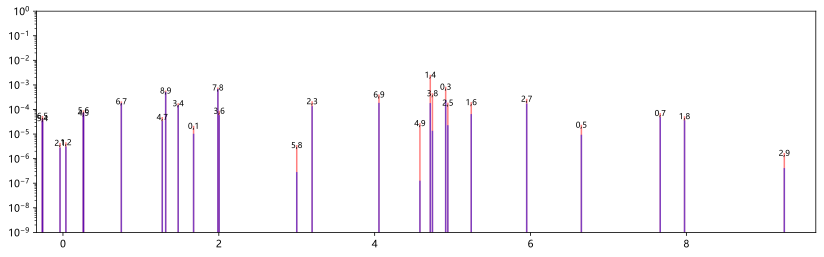

In [71]:
fig, ax = plt.subplots(1,1, figsize = (14,4))
ymin = 1e-9
ymax = 1
xmin = Er-5
xmax = Er+5
dressed_gamma_arr  = np.abs( kappa_osc*osc_c_ops_wrapped.full()) + np.abs(np.square(qbt_c_ops_wrapped.full()) )
qbt_bare_gamma_arr = np.abs(np.square(qbt_c_ops.full()))
for ql1 in qls:
    for ql2 in qls:
        new_ql1 = system.product_to_dressed[(ql1,0)]
        new_ql2 = system.product_to_dressed[(ql2,0)]

        dressed_frequency = system.evals[new_ql2] -system.evals[new_ql1]
        dressed_decay_rate = dressed_gamma_arr[new_ql1,new_ql2]

        bare_frequency  = gf_IFQ.evals[ql2] - gf_IFQ.evals[ql1]
        bare_decay_rate = qbt_bare_gamma_arr[ql1,ql2]
        if bare_decay_rate < 1e-10:
            bare_decay_rate = 1e-10
        ax.plot([dressed_frequency,dressed_frequency], [0,dressed_decay_rate], color='red',alpha  = 0.5)
        ax.plot([bare_frequency,dressed_frequency], [0,bare_decay_rate], color='blue',alpha  = 0.5)
        
        # ax.plot([bare_frequency,dressed_frequency], [0,dressed_decay_rate/bare_decay_rate], color='blue',alpha  = 0.5)
        if dressed_decay_rate > ymin and bare_frequency> xmin and bare_frequency<xmax:
            ax.text(dressed_frequency,dressed_decay_rate,f"{ql1},{ql2}",va='center',ha='center',size=8)
ax.set_yscale('log')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)

In [72]:
new_ql1 = system.product_to_dressed[(resonator_hybrid_ql1,0)]
new_ql2 = system.product_to_dressed[(resonator_hybrid_ql2,0)]

dressed_decay_rate = dressed_gamma_arr[new_ql1,new_ql2]

bare_decay_rate = qbt_bare_gamma_arr[resonator_hybrid_ql1,resonator_hybrid_ql2]

dressed_decay_rate,bare_decay_rate

(0.002404882621919845, 0.00017045508909392022)

# Use the dressed decay rates to simulate qubit

In [73]:
dressed_gamma_arr_qbt = np.zeros(shape=(max_ql,max_ql))
for ql1 in qls:
    for ql2 in qls:
        new_ql1 = system.product_to_dressed[(ql1,0)]
        new_ql2 = system.product_to_dressed[(ql2,0)]
        dressed_gamma_arr_qbt[ql1,ql2] = dressed_gamma_arr[new_ql1,new_ql2]

c_ops = qutip.Qobj(np.sqrt(dressed_gamma_arr_qbt))

# Purcell with drive

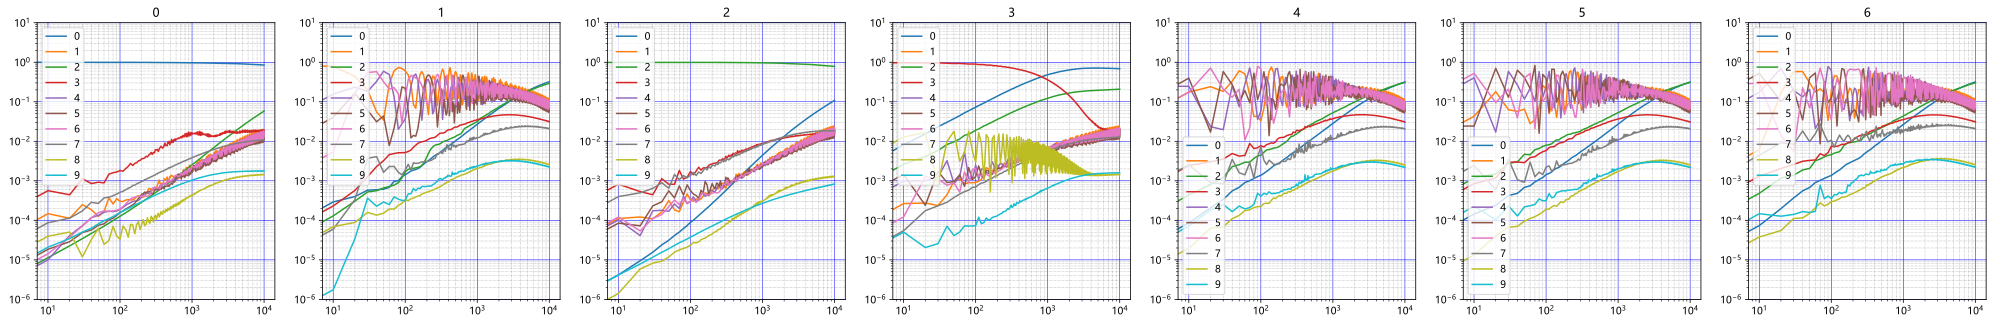

In [87]:
e_ops = [qutip.ket2dm(qutip.basis(gf_IFQ.truncated_dim, i)) for i in range(max_ql)]
tlist = np.linspace(0, int(1e4), 1000)

pi_period = 200


qls = [0,1,2,3,4,5,6]
results  = gf_IFQ.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(gf_IFQ.truncated_dim, i) for i in qls],
    tlist = tlist,
    drive_terms = [DriveTerm(
                    driven_op=qutip.Qobj(
                        gf_IFQ.fluxonium.n_operator(energy_esys=True)),
                    pulse_shape_func=square_pulse_with_rise_fall,
                    pulse_id='14',
                    pulse_shape_args={
                        'w_d': gf_IFQ.evals[4]-gf_IFQ.evals[1],  # Without 2pi
                        'amp': np.pi / pi_period / np.abs(gf_IFQ.fluxonium.n_operator(energy_esys=True)[1,4]),  # Without 2pi
                        't_square': 1e4,
                    }),
                    DriveTerm(
                    driven_op=qutip.Qobj(
                        gf_IFQ.fluxonium.n_operator(energy_esys=True)),
                    pulse_shape_func=square_pulse_with_rise_fall,
                    pulse_id='45',
                    pulse_shape_args={
                        'w_d': gf_IFQ.evals[5]-gf_IFQ.evals[4],  # Without 2pi
                        'amp':  np.pi / pi_period / np.abs(gf_IFQ.fluxonium.n_operator(energy_esys=True)[4,5]),  # Without 2pi
                        't_square': 1e4,
                    }),
                    DriveTerm(
                    driven_op=qutip.Qobj(
                        gf_IFQ.fluxonium.n_operator(energy_esys=True)),
                    pulse_shape_func=square_pulse_with_rise_fall,
                    pulse_id='56',
                    pulse_shape_args={
                        'w_d': gf_IFQ.evals[6]-gf_IFQ.evals[5],  # Without 2pi
                        'amp':  np.pi / pi_period / np.abs(gf_IFQ.fluxonium.n_operator(energy_esys=True)[5,6]),  # Without 2pi
                        't_square': 1e4,
                    }),
                    ],

    c_ops = c_ops,
    e_ops = e_ops
)

fig, axes = plt.subplots(1,len(qls),figsize= (len(qls)*5,5))
for ql, result, ax in zip(qls,
                          results,
                          axes.flatten()):
    for i, exp in enumerate(result.expect[:11]):
        ax.plot(tlist,exp,label= f"{i}")
    ax.legend()
    ax.set_title(f"{ql}")
    ax.set_yscale('log')
    ax.set_ylim(1e-6,1e1)
    ax.set_xscale('log')

    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='blue')  # Major grid
    ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')  # Minor grid
    ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))


# Purcell without drive

 Total run time:  22.01s*] Elapsed 22.01s / Remaining 00:00:00:00 [*********97%********** ] Elapsed 21.49s / Remaining 00:00:00:00 [*********60%**         ] Elapsed 13.79s / Remaining 00:00:00:09
 Total run time:  25.53s*] Elapsed 25.53s / Remaining 00:00:00:00 [*********86%********   ] Elapsed 25.46s / Remaining 00:00:00:04
 Total run time:  28.54s*] Elapsed 28.54s / Remaining 00:00:00:00
 Total run time:  30.42s*] Elapsed 30.42s / Remaining 00:00:00:00 [*********76%*****      ] Elapsed 30.08s / Remaining 00:00:00:09
 Total run time:  31.15s*] Elapsed 31.15s / Remaining 00:00:00:00 [*********79%******     ] Elapsed 30.90s / Remaining 00:00:00:08
 Total run time:  34.89s*] Elapsed 34.89s / Remaining 00:00:00:00
 Total run time:  36.70s*] Elapsed 36.70s / Remaining 00:00:00:00


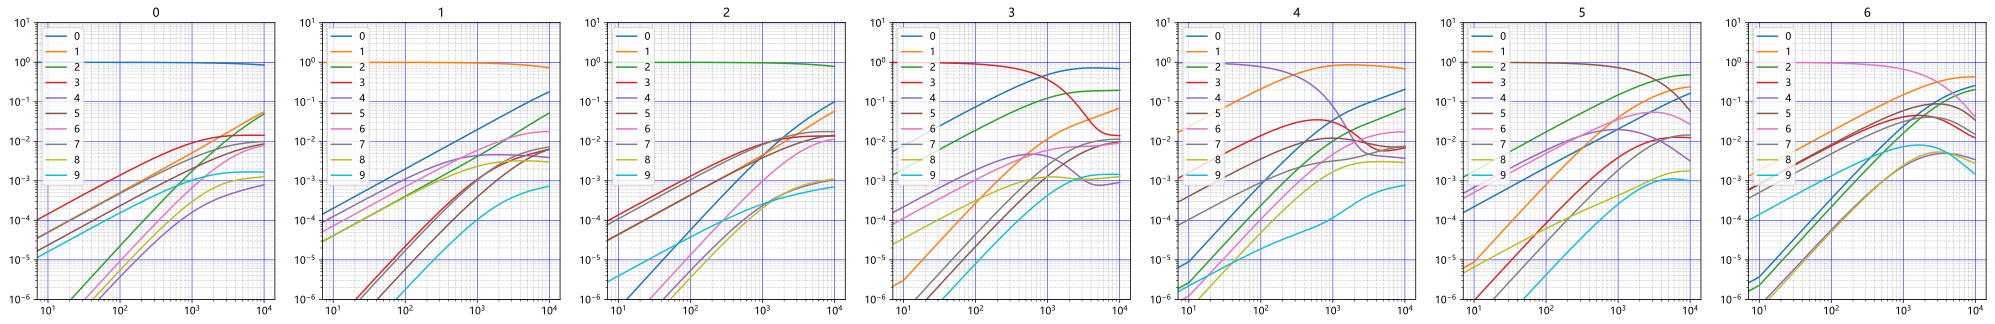

In [89]:
e_ops = [qutip.ket2dm(qutip.basis(gf_IFQ.truncated_dim, i)) for i in range(max_ql)]
tlist = np.linspace(0, int(1e4), 1000)

pi_period = 200


qls = [0,1,2,3,4,5,6]
results  = gf_IFQ.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(gf_IFQ.truncated_dim, i) for i in qls],
    tlist = tlist,
    drive_terms = [],

    c_ops = c_ops,
    e_ops = e_ops
)

fig, axes = plt.subplots(1,len(qls),figsize= (len(qls)*5,5))
for ql, result, ax in zip(qls,
                          results,
                          axes.flatten()):
    for i, exp in enumerate(result.expect[:11]):
        ax.plot(tlist,exp,label= f"{i}")
    ax.legend()
    ax.set_title(f"{ql}")
    ax.set_yscale('log')
    ax.set_ylim(1e-6,1e1)
    ax.set_xscale('log')

    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='blue')  # Major grid
    ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')  # Minor grid
    ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))


# No purcell no drive

 Total run time:   7.54s*] Elapsed 7.54s / Remaining 00:00:00:00 [****     16%           ] Elapsed 7.24s / Remaining 00:00:00:37
 Total run time:   7.57s*] Elapsed 7.57s / Remaining 00:00:00:00
 Total run time:   7.80s*] Elapsed 7.80s / Remaining 00:00:00:00 [****     17%           ] Elapsed 7.57s / Remaining 00:00:00:36
 Total run time:  21.30s*] Elapsed 21.30s / Remaining 00:00:00:00 [*********47%           ] Elapsed 19.31s / Remaining 00:00:00:21
 Total run time:  28.87s*] Elapsed 28.87s / Remaining 00:00:00:00
 Total run time:  34.59s*] Elapsed 34.59s / Remaining 00:00:00:00
 Total run time:  38.51s*] Elapsed 38.51s / Remaining 00:00:00:00


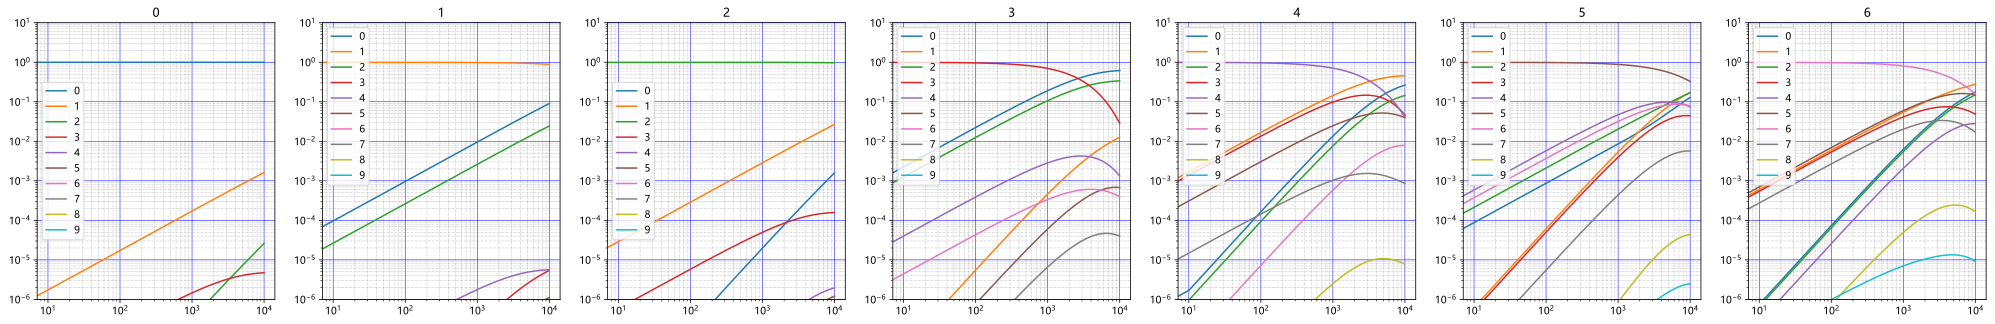

In [88]:
e_ops = [qutip.ket2dm(qutip.basis(gf_IFQ.truncated_dim, i)) for i in range(max_ql)]
tlist = np.linspace(0, int(1e4), 1000)

pi_period = 200


qls = [0,1,2,3,4,5,6]
results  = gf_IFQ.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(gf_IFQ.truncated_dim, i) for i in qls],
    tlist = tlist,
    drive_terms = [],

    c_ops = gf_IFQ.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude),
    e_ops = e_ops
)
fig, axes = plt.subplots(1,len(qls),figsize= (len(qls)*5,5))
for ql, result, ax in zip(qls,
                          results,
                          axes.flatten()):
    for i, exp in enumerate(result.expect[:11]):
        ax.plot(tlist,exp,label= f"{i}")
    ax.legend()
    ax.set_title(f"{ql}")
    ax.set_yscale('log')
    ax.set_ylim(1e-6,1e1)
    ax.set_xscale('log')

    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='blue')  # Major grid
    ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')  # Minor grid
    ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
